## MNIST Convolutional Neural Network Classifier With Keras
> Created by: Samuel Madden

> Created on: December 15, 2019
> Last Updated : March 9, 2020

In [1]:
# AWS IAM Role
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()


# default imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

# TensorFlow base
# Keras imports
#import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

# Ouptut System Versions
print("Python Version: " + sys.version)
print("Pandas Version: " + pd.__version__)

Using TensorFlow backend.



Python Version: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
Pandas Version: 0.24.2


## 1. Introduction

The MNIST dataset is an image dataset of handwritten digits made available by Yann LeCun et. al. <a href = "http://yann.lecun.com/exdb/mnist/">here</a>. It has has 60,000 training images and 10,000 test images, each of which are grayscale 28 x 28 sized images.

## 2. Data Preparation

### 2.1 Import

In [2]:
# Using .read_csv commands if dataset is local

#mnist_train = pd.read_csv('mnist/mnist_train.csv')
#mnist_test = pd.read_csv('mnist/mnist_test.csv')

# Import dataset using Keras Library
from keras.datasets.mnist import load_data

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

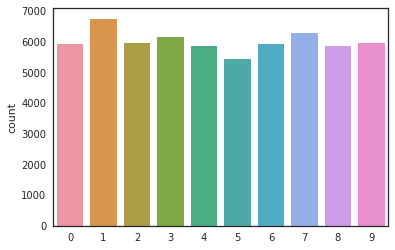

In [3]:
#X_train, Y_train = mnist_train.iloc[:,1:], mnist_train['label']
#X_test, Y_test = mnist_test.iloc[:, 1:], mnist_test['label']

(X_train, Y_train),(X_test, Y_test) = load_data()

g = sns.countplot(Y_train)

np.unique(Y_train, return_counts=True)

All labels (0-9) are accounted for in the above value count with 
no unexpected Null or -1 instances.

The labels between 0 - 9 are also relatively evenly distributed

In [4]:
# note dimension of data images
# img_rows, img_cols = 28, 28

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### 2.2 Scan for Null/Missing Values

In [5]:
#np.isnan(X_train)
#np.isnan(X_test)

In [6]:
# cmds if data was in Pandas.DataFrame format
#X_test.isnull().any().describe()
#X_test.isnull().any().descrive()

### 2.3 Normalization

Perform a grayscale normalization: by default the image set is grayscale

Convert the pixel lumination from a value between 0 - 255 to a scale of 0 - 1

In [7]:
#X_train = X_train / 255.0
#X_test = X_test / 255.0

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

### 2.4 Reshape

The data images are 28px X 28px. These images are reshaped to 2D representation of 1 x 784
in the MNIST dataset.

In [8]:
# Reshape image in 3 dimensions (height = 28, width = 28, chanal = 1)

# check image shape
#X_train[0].shape

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
num_channels = 1 #images are grayscale


#X_train = X_train.values.reshape(-1, img_rows, img_cols, 1)
X_trainK = np.reshape(X_train,(X_train.shape[0],img_rows, img_cols, num_channels))
#X_test = X_test.values.reshape(-1, img_rows, img_cols, 1)
X_testK = np.reshape(X_test,(X_test.shape[0],img_rows, img_cols, num_channels))

</br>
Keras requires a 3 dimensional input to correspond to height, width and channel.</br>
In the case of MNIST, the images are grayscale and require one channel.

In [9]:
# X_train
print("X_train info: ")
print("Type: ", type(X_train))
print("Dimensions: ", X_train.ndim)
print("Type var stored: ", X_train.dtype)
print("X_trainK shape at [1]: ", X_trainK.shape)
print("")
print("\n")

# X_test
print("X_test info: ")
print("Type: ", type(X_test))
print("Dimensions: ", X_test.ndim)
print("Type var stored: ", X_test.dtype)
print("X_testK shape: ", X_testK.shape)

X_train info: 
Type:  <class 'numpy.ndarray'>
Dimensions:  3
Type var stored:  float32
X_trainK shape at [1]:  (60000, 28, 28, 1)



X_test info: 
Type:  <class 'numpy.ndarray'>
Dimensions:  3
Type var stored:  float32
X_testK shape:  (10000, 28, 28, 1)


### 2.5 Label Encoding

Labels are 10 single digits 0 - 9. </br>
&#09;&nbsp;&bull; Convert each digit to a corresponding hot vector ex. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]. This allows for identification due to the corresponding activation of one of the 10 output neurons.</br>
&nbsp;&bull; Again this transforms the data from type pandas.DataFrame to a np.ndarray.

In [10]:
num_classes = 10
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

In [11]:
# Y_train
print("Y_train info: ")
print("Type: ", type(Y_train))
print("Dimensions: ", Y_train.ndim)
print("Type var stored: ", Y_train.dtype)
print("Y_train shape: ", Y_train.shape)

Y_train info: 
Type:  <class 'numpy.ndarray'>
Dimensions:  2
Type var stored:  float32
Y_train shape:  (60000, 10)


### 2.6 Splitting Training and Validation Set

&bull; 10% is partitioned to the evaluation set while the remaining 90% is used to train the model. </br>
&bull; A random split of the training data is admissable as we have already established that the distribution of labels is consistent across the data set (see 2.1). This ensures no overrepresentation of certain labels in the X_train/Y_train and X_val/Y_val.</br>
&bull; This is not always the case and for unbalanced datasets use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

In [12]:
# set random seed
random_seed = 2

In [13]:
# Split the train and validation sets for fitting the model
X_trainData, X_val, Y_trainData, Y_val = train_test_split(X_trainK, Y_train, test_size = 0.1, random_state=random_seed)

In [14]:
print("X_trainData shape: ", X_trainData.shape)
print("Y_trainData shape: ", Y_trainData.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X_trainData shape:  (54000, 28, 28, 1)
Y_trainData shape:  (54000, 10)
X_val shape:  (6000, 28, 28, 1)
Y_val shape:  (6000, 10)


Print a sample element of the X_train dataset

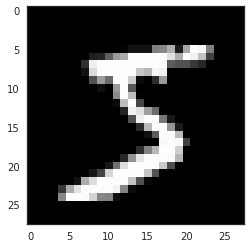

In [15]:
plt.imshow(X_train[0],cmap='gray')
plt.show()

## 3. CNN

### 3.1 Defining the Model

The Keras data model type will be set to 'Sequential', in which the model is built one layer at a time.

&nbsp; &bull; add() function will add layers to the model individually<br>
&nbsp; &bull; The inputs of 32 & 64 refer to the number of nodes in specific layer


Conv2D layers are convolutional layers that deal with the 2 dimensional matrix input (a.k.a. input images).<br> 
This is a learnable filter that is a transformation on the image defined by the kernel size

&nbsp; &bull; Kernel size refers to the size of the filter matrix for the convolutional layer. Size=3 means a 3x3 conv matrix<br>
&nbsp; &bull; Activation function is set to ReLU define by y=max(0,x), which lends to model sparsity and faster convergence.<br>
&nbsp; &bull; MaxPool2D picks the max value of the neighboring pool<br>

The Flatten layer converts the final feature maps into a single 1D vector.

Dense refers to the fact that each neuron of a layer are connected to all the neurons of the layer previous.

Dropout randomly selects nodes to be ignored(set w=0), promoting distributed learning, generalization and reducing overfitting.

The output layer consists of 10 nodes, representing the classification options of 0-9<br>
&nbsp; &bull; 'softmax' has the output layer sum to 1 allowing the output nodes to be interpreted as probabilities of their corresponding number.

In [16]:
# Create the CNN model

# Architexture: Input -> [[Conv2D->ReLU]*2 -> MaxPool2D -> Dropout] * 2 -> 
#  Flatten -> Dense -> Dropout -> Output

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (img_rows,img_cols,num_channels)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### 3.2 Compiling the Model

Settup Metrics, Loss Function and Optimizer algorithm

&nbsp;&bull;&nbsp;Metric: Accuracy<br>
&nbsp;&bull;&nbsp;Loss Funtion: Cross Entropy<br>
&nbsp;&bull;&nbsp;Optimization: Adam (Stochastic Optimization)

In [17]:
model.compile(metrics=["accuracy"],loss = 'categorical_crossentropy', optimizer = 'adam')

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

### 3.3 Fitting the Model to the data

In [19]:
hist = model.fit(X_trainData, Y_trainData,  
          batch_size=64,
          epochs=10,
          validation_data=(X_val, Y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samples, validate on 6000 samples
Epoch 1/10





54000/54000 [==============================] - 318s 6ms/step - loss: 0.2246 - acc: 0.9292 - val_loss: 0.0532 - val_acc: 0.9837
Epoch 2/10
54000/54000 [==============================] - 313s 6ms/step - loss: 0.0767 - acc: 0.9769 - val_loss: 0.0330 - val_acc: 0.9895
Epoch 3/10
54000/54000 [==============================] - 320s 6ms/step - loss: 0.0560 - acc: 0.9829 - val_loss: 0.0361 - val_acc: 0.9905
Epoch 4/10
54000/54000 [==============================] - 378s 7ms/step - loss: 0.0480 - acc: 0.9857 - val_loss: 0.0250 - val_acc: 0.9928
Epoch 5/10
54000/54000 [==============================] - 375s 7ms/step - loss: 0.0419 - acc: 0.9874 - val_loss: 0.0240 - val_acc: 0.9933
Epoch 6/10
54000/54000 [==============================] - 378s 7ms/step - loss: 0.0342 - acc: 0.9896 - val_loss: 0.0237 - val_acc: 0.9928
Epoch 7/10
54000/5400

### 3.4 Basic Plotting and Evalutation of Model

In [22]:
score = model.evaluate(X_testK, Y_test, verbose=0)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.022750989502215907
Test accuracy:  0.9943


In [23]:
#bucket ='sagemaker-studio-thaaoml7ipn'

#data_location = 's3://{}/{}'.format(bucket, data_key_test)

model.save('mnist_cnn.h5')

In [24]:
# Create a confusion matrix

# Below code block is from SKLearn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

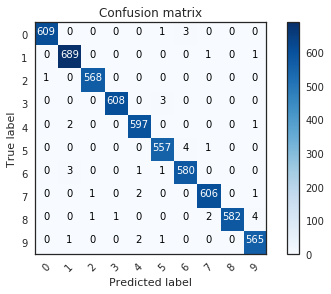

In [25]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Graph elbow curve

In [27]:
#print(hist.history.keys())
accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

Visualize common misidentified images

In [ ]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### 3.5 Classification Report

## 4. Summary and Conclusion